In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch

import numpy as np
import torch.nn as nn

from peft import AutoPeftModelForCausalLM, get_peft_model, get_peft_config, TaskType, LoraConfig

from diffusers import DiffusionPipeline, StableDiffusionXLPipeline
from tqdm.auto import tqdm
from captum.attr import IntegratedGradients
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer
from diffusers import EulerDiscreteScheduler, UNet2DConditionModel, AutoencoderKL

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_path = '/data/junlei/project-code/diffusion/models/stable-diffusion-xl-base-1.0'

text_encoder = CLIPTextModel.from_pretrained(model_path, subfolder='text_encoder', torch_dtype=torch.float16, variant='fp16', use_safetensors=True).to("cuda")
text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(model_path, subfolder='text_encoder_2', torch_dtype=torch.float16, variant='fp16', use_safetensors=True).to("cuda")
tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder='tokenizer', torch_dtype=torch.float16, variant='fp16', use_safetensors=True)
tokenizer_2 = CLIPTokenizer.from_pretrained(model_path, subfolder='tokenizer_2', torch_dtype=torch.float16, variant='fp16', use_safetensors=True)
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder='unet', torch_dtype=torch.float16, variant='fp16', use_safetensors=True).to("cuda")
vae = AutoencoderKL.from_pretrained(model_path, subfolder='vae', torch_dtype=torch.float16, variant='fp16', use_safetensors=True).to("cuda")
scheduler = EulerDiscreteScheduler.from_pretrained(model_path, subfolder='scheduler', torch_dtype=torch.float16, variant='fp16', use_safetensors=True)

# unet.state_dict()
unet, scheduler


# text_encoder, tokenizer


(UNet2DConditionModel(
   (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (time_proj): Timesteps()
   (time_embedding): TimestepEmbedding(
     (linear_1): Linear(in_features=320, out_features=1280, bias=True)
     (act): SiLU()
     (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
   )
   (add_time_proj): Timesteps()
   (add_embedding): TimestepEmbedding(
     (linear_1): Linear(in_features=2816, out_features=1280, bias=True)
     (act): SiLU()
     (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
   )
   (down_blocks): ModuleList(
     (0): DownBlock2D(
       (resnets): ModuleList(
         (0-1): 2 x ResnetBlock2D(
           (norm1): GroupNorm(32, 320, eps=1e-05, affine=True)
           (conv1): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
           (time_emb_proj): Linear(in_features=1280, out_features=320, bias=True)
           (norm2): GroupNorm(32, 320, eps=1e-05, affine=True)
         

In [2]:
for name, module in unet.named_modules():
    if isinstance(module, nn.Linear) and any(x in name for x in ['to_q', 'to_k', 'to_v']):
        print(">>>", name, module.__class__.__name__)
        model = unet
        module_keys = name.split('.')
        for key in module_keys:
            if key.isdigit():
                model = model[int(key)]
            else:
                model  = getattr(model, key)
        print(model, model.state_dict())
        break

        params = model.state_dict()

>>> down_blocks.1.attentions.0.transformer_blocks.0.attn1.to_q Linear
Linear(in_features=640, out_features=640, bias=False) OrderedDict([('weight', tensor([[ 0.0219,  0.0321, -0.0284,  ..., -0.0244,  0.0385, -0.0293],
        [ 0.0409, -0.0521,  0.0646,  ..., -0.0111, -0.0356,  0.0857],
        [-0.0544,  0.0109, -0.0184,  ...,  0.0098, -0.0300, -0.0710],
        ...,
        [ 0.0122, -0.0166, -0.0231,  ..., -0.0767,  0.0309, -0.1163],
        [-0.0403,  0.1021, -0.0101,  ..., -0.0273,  0.0138, -0.0528],
        [ 0.0281, -0.0084, -0.0776,  ..., -0.0097,  0.0293, -0.0147]],
       device='cuda:0', dtype=torch.float16))])


In [3]:
text_encoder_ig = IntegratedGradients(text_encoder)
text_encoder_2_ig = IntegratedGradients(text_encoder_2)
tokenizer_ig = IntegratedGradients(tokenizer)
tokenizer_2_ig = IntegratedGradients(tokenizer_2)

unet_ig = IntegratedGradients(unet)
vae_ig = IntegratedGradients(vae)
scheduler_ig = IntegratedGradients(scheduler)

In [31]:
prompt = "a photo of a doctor"

generator = torch.manual_seed(30)
num_inference_steps = 75  
n_steps = 40
high_noise_frac = 0.8
height = 512
width = 512

generate_picture_num = 1   

cfg_scales = [1.1, 8, 12]   #  the affect level of prompt
guidance_scale = 7.5
batch_size = 1

latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    dtype=torch.float16,
).to(device)

scheduler.set_timesteps(num_inference_steps)


/tmp/ipykernel_1284095/567583503.py:17: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [32]:
text_input = tokenizer(
    prompt, 
    padding='max_length',
    max_length=tokenizer.model_max_length,
    truncation=True,
    torch_dtype=torch.float16,
    return_tensors="pt"
)

text_input_ids = text_input.input_ids

with torch.no_grad():
    prompt_embeds = text_encoder(text_input_ids.to(device), output_hidden_states=True)

prompt_embeds.pooler_output, prompt_embeds.hidden_states



Keyword arguments {'torch_dtype': torch.float16} not recognized.


(tensor([[-1.5942e-01,  2.4133e-01, -1.2061e-01,  2.9492e-01, -4.6973e-01,
          -1.2363e+00, -2.7246e-01, -1.0674e+00,  1.7896e-01,  2.5952e-01,
          -6.0547e-01,  1.2002e+00, -2.8320e-01, -1.4014e+00,  3.3252e-01,
           7.2693e-02, -6.9922e-01,  2.6343e-01,  4.7588e-04,  1.5820e+00,
           1.7273e-01,  3.3545e-01, -5.9766e-01, -4.1431e-01,  1.9751e-01,
          -2.1152e+00,  1.6875e+00, -7.9639e-01, -4.6069e-01,  3.5913e-01,
           8.8916e-01,  1.5332e+00, -4.9805e-02, -1.9434e-01,  3.2983e-01,
           5.6445e-01, -1.6943e+00,  7.0984e-02,  8.3301e-01, -1.2246e+00,
           9.2090e-01,  8.2336e-02, -3.2861e-01, -2.2148e+00, -1.2793e+00,
           7.5488e-01, -7.6416e-01,  1.4124e-01, -1.5271e-01, -1.4819e-01,
           1.1987e-01,  1.8008e+00, -1.0547e+00,  7.6965e-02, -1.7593e-02,
          -1.8945e+00, -3.2532e-02, -9.7900e-01,  6.5979e-02, -1.1152e+00,
          -4.8657e-01,  2.3962e-01,  2.2217e-02,  1.1631e+00,  4.5264e-01,
           6.5625e-01,  6

In [33]:
'''采样过程可视化'''

def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [34]:
pipe = DiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to(device)

pipe.unet
refiner = DiffusionPipeline.from_pretrained(
    model_path,
    text_encoder_2=pipe.text_encoder_2,
    vae=pipe.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to(device)

n_steps = 40

image = pipe(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latents",
).images
print("#####################")
image = refiner(
    prompt=prompt,
    num_images_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

/home/junlei/anaconda3/envs/com_diffusion/lib/python3.9/site-packages/diffusers/image_processor.py:627: FutureWarning: the output_type latents is outdated and has been set to `np`. Please make sure to set it to one of these instead: `pil`, `np`, `pt`, `latent`
  deprecate("Unsupported output_type", "1.0.0", deprecation_message, standard_warn=False)


#####################


  0%|          | 0/50 [00:00<?, ?it/s]

In [35]:

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents.detach).sample


  0%|          | 0/75 [00:00<?, ?it/s]

NameError: name 'text_embeddings' is not defined

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

'Image at step 976.0'

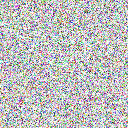

'Image at step 951.0'

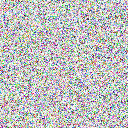

'Image at step 926.0'

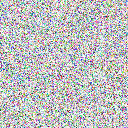

'Image at step 901.0'

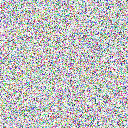

'Image at step 876.0'

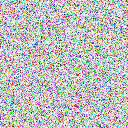

'Image at step 851.0'

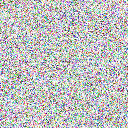

'Image at step 826.0'

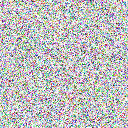

'Image at step 801.0'

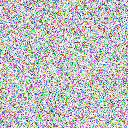

'Image at step 776.0'

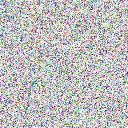

'Image at step 751.0'

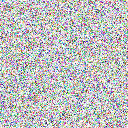

'Image at step 726.0'

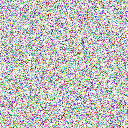

'Image at step 701.0'

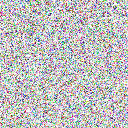

'Image at step 676.0'

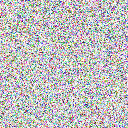

'Image at step 651.0'

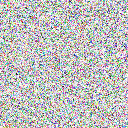

'Image at step 626.0'

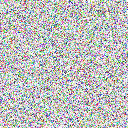

'Image at step 601.0'

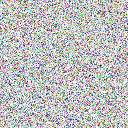

'Image at step 576.0'

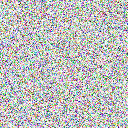

'Image at step 551.0'

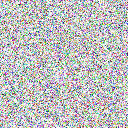

'Image at step 526.0'

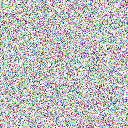

'Image at step 501.0'

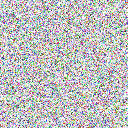

'Image at step 476.0'

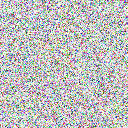

'Image at step 451.0'

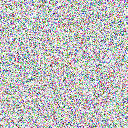

'Image at step 426.0'

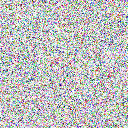

'Image at step 401.0'

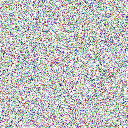

'Image at step 376.0'

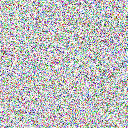

'Image at step 351.0'

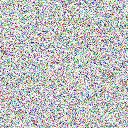

'Image at step 326.0'

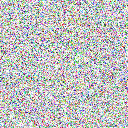

'Image at step 301.0'

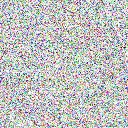

'Image at step 276.0'

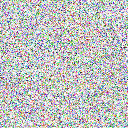

'Image at step 251.0'

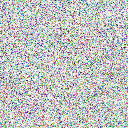

'Image at step 226.0'

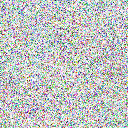

'Image at step 201.0'

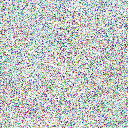

#####################


  0%|          | 0/50 [00:00<?, ?it/s]

'Image at step 981.0'

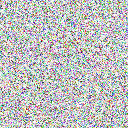

'Image at step 961.0'

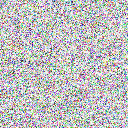

'Image at step 941.0'

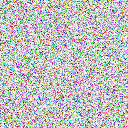

'Image at step 921.0'

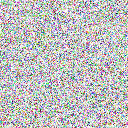

'Image at step 901.0'

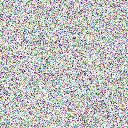

'Image at step 881.0'

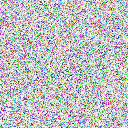

'Image at step 861.0'

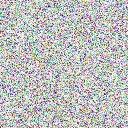

'Image at step 841.0'

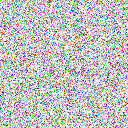

'Image at step 821.0'

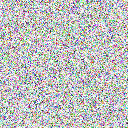

'Image at step 801.0'

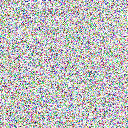

'Image at step 781.0'

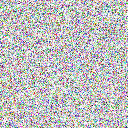

'Image at step 761.0'

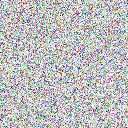

'Image at step 741.0'

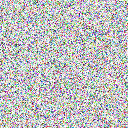

'Image at step 721.0'

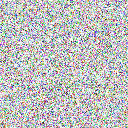

'Image at step 701.0'

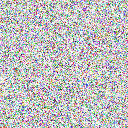

'Image at step 681.0'

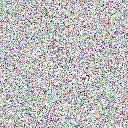

'Image at step 661.0'

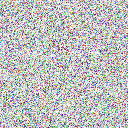

'Image at step 641.0'

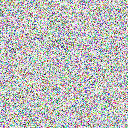

'Image at step 621.0'

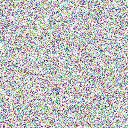

'Image at step 601.0'

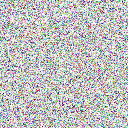

'Image at step 581.0'

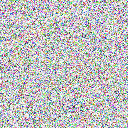

'Image at step 561.0'

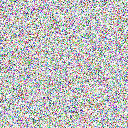

'Image at step 541.0'

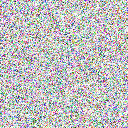

'Image at step 521.0'

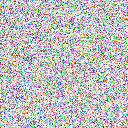

'Image at step 501.0'

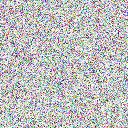

'Image at step 481.0'

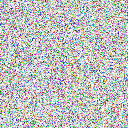

'Image at step 461.0'

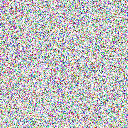

'Image at step 441.0'

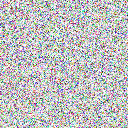

'Image at step 421.0'

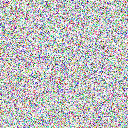

'Image at step 401.0'

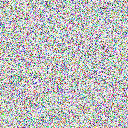

'Image at step 381.0'

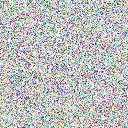

'Image at step 361.0'

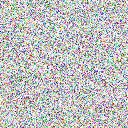

'Image at step 341.0'

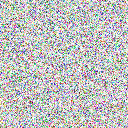

'Image at step 321.0'

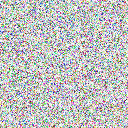

'Image at step 301.0'

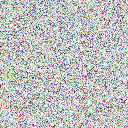

'Image at step 281.0'

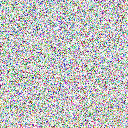

'Image at step 261.0'

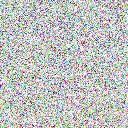

'Image at step 241.0'

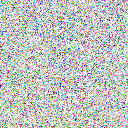

'Image at step 221.0'

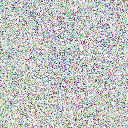

'Image at step 201.0'

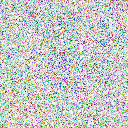

'Image at step 181.0'

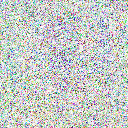

'Image at step 161.0'

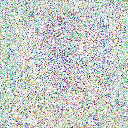

'Image at step 141.0'

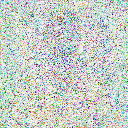

'Image at step 121.0'

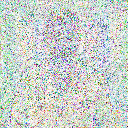

'Image at step 101.0'

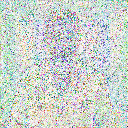

'Image at step 81.0'

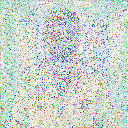

'Image at step 61.0'

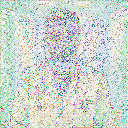

'Image at step 41.0'

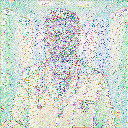

'Image at step 21.0'

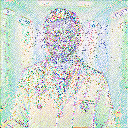

'Image at step 1.0'

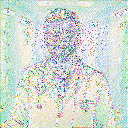

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

import torch

from PIL import Image
from captum.attr import IntegratedGradients
from StableDiffusionXL import StableDiffusionXLPipeline
from transformers import CLIPTextModel, CLIPTextModelWithProjection, CLIPTokenizer
from diffusers import EulerDiscreteScheduler, UNet2DConditionModel, AutoencoderKL

from diffusers.loaders import (
    StableDiffusionXLLoraLoaderMixin,
    TextualInversionLoaderMixin,
)

from diffusers.utils import (
    USE_PEFT_BACKEND,
    deprecate,
    is_invisible_watermark_available,
    is_torch_xla_available,
    logging,
    replace_example_docstring,
    scale_lora_layers,
    unscale_lora_layers,
)
from diffusers.models.lora import adjust_lora_scale_text_encoder
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_path = '/data/junlei/project-code/diffusion/models/stable-diffusion-xl-base-1.0'

text_encoder = CLIPTextModel.from_pretrained(model_path, subfolder='text_encoder', torch_dtype=torch.float16, variant='fp16', use_safetensors=True).to("cuda")
text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(model_path, subfolder='text_encoder_2', torch_dtype=torch.float16, variant='fp16', use_safetensors=True).to("cuda")
tokenizer = CLIPTokenizer.from_pretrained(model_path, subfolder='tokenizer', torch_dtype=torch.float16, variant='fp16', use_safetensors=True)
tokenizer_2 = CLIPTokenizer.from_pretrained(model_path, subfolder='tokenizer_2', torch_dtype=torch.float16, variant='fp16', use_safetensors=True)
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder='unet', torch_dtype=torch.float16, variant='fp16', use_safetensors=True).to("cuda")


def main():
    prompt = "a photo of a doctor"

    generator = torch.manual_seed(120)
    num_inference_steps = 75  
    n_steps = 40
    high_noise_frac = 0.8
    height = 512
    width = 512

    generate_picture_num = 1   

    pipe = StableDiffusionXLPipeline.from_pretrained(model_path, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
    pipe.to(device)

    refiner = StableDiffusionXLPipeline.from_pretrained(
        model_path,
        text_encoder_2=pipe.text_encoder_2,
        vae=pipe.vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
    )
    refiner.to(device)

    n_steps = 40

    image = pipe(
        prompt=prompt,
        num_inference_steps=n_steps,
        denoising_end=high_noise_frac,
        output_type="latents",
    ).images
    print("#####################")

    image = refiner(
        prompt=prompt,
        num_images_steps=n_steps,
        denoising_start=high_noise_frac,
        image=image,
    ).images[0]

    # pipe_ig = IntegratedGradients(
    #      pipe(
    #         prompt=prompt,
    #         num_inference_steps=n_steps,
    #         denoising_end=high_noise_frac,
    #         output_type="latents",
    #     )
    # )
    # refiner_ig = IntegratedGradients(
    #     refiner(
    #         prompt=prompt,
    #         num_images_steps=n_steps,
    #         denoising_start=high_noise_frac,
    #         image=image,
    #     )
    # )

    # prompt_embeding = encode_prompt(
    #     prompt=prompt,
    #     device=device,
    # )
    # print(prompt_embeding, type(prompt_embeding))
    # baseline = torch.zeros_like(prompt_embeding)

    # attributions, delta = pipe_ig.attribute(prompt_embeding, baselines=baseline, additional_forward_args=1, return_convergence_delta=True)
    # print("attributions:", attributions, "\n", "delta:", delta)

    image.save('output.png')

main()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ToyModel(nn.Module):
    r"""
    Example toy model from the original paper (page 10)

    https://arxiv.org/pdf/1703.01365.pdf


    f(x1, x2) = RELU(ReLU(x1) - 1 - ReLU(x2))
    """

    def __init__(self):
        super().__init__()

    def forward(self, input1, input2):
        relu_out1 = F.relu(input1)
        relu_out2 = F.relu(input2)
        return F.relu(relu_out1 - 1 - relu_out2)
    
from captum.attr import IntegratedGradients
model = ToyModel()

# defining model input tensors
input1 = torch.tensor([3.0], requires_grad=True)
input2 = torch.tensor([1.0], requires_grad=True)

# defining baselines for each input tensor
baseline1 = torch.tensor([0.0])
baseline2 = torch.tensor([0.0])

# defining and applying integrated gradients on ToyModel and the
ig = IntegratedGradients(model)
attributions, approximation_error = ig.attribute((input1, input2),
                                                 baselines=(baseline1, baseline2),
                                                 method='gausslegendre',
                                                 return_convergence_delta=True)


attributions, approximation_error

TypeError: forward() missing 3 required positional arguments: 'sample', 'timestep', and 'encoder_hidden_states'